In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    classification_report,
    confusion_matrix
)

# -------------------------------------------------------------------
# 0. CARGAR DATOS
# -------------------------------------------------------------------
path_excel = r"C:\Users\Asus\Documents\Maestría\TESIS\ORTO\datos_completos.xlsx"
df = pd.read_excel(path_excel)

print("Columnas del DataFrame:")
print(df.columns)

# Aseguramos formato de la columna Fecha
df["Fecha"] = df["Fecha"].astype(str).str.lower().str.strip()

# -------------------------------------------------------------------
# 1. MODELO DE REGRESIÓN: ÍNDICES → CAROT_TOT
# -------------------------------------------------------------------
# Lista de índices que queremos usar (los que existan en tu archivo)
index_cols_candidatas = ["NDVI", "GNDVI", "VARI", "NDRE", "CRI", "PSRI"]

# Nos quedamos solo con las que realmente están en df
feature_cols_reg = [c for c in index_cols_candidatas if c in df.columns]

if "Carot_tot" not in df.columns:
    raise ValueError("No encuentro la columna 'Carot_tot' en el Excel. Asegúrate de que exista.")

if len(feature_cols_reg) == 0:
    raise ValueError(
        "No encontré ninguna de estas columnas de índices en el DataFrame: "
        + ", ".join(index_cols_candidatas)
    )

print("\n[REGRESIÓN] Columnas usadas como X:", feature_cols_reg)
print("[REGRESIÓN] Columna objetivo (y): Carot_tot")

X_reg = df[feature_cols_reg].values
y_reg = df["Carot_tot"].values

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

reg = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

reg.fit(X_train_reg, y_train_reg)
y_pred_reg = reg.predict(X_test_reg)

# Métricas de regresión
# Métricas de regresión
r2 = r2_score(y_test_reg, y_pred_reg)
rmse = mean_squared_error(y_test_reg, y_pred_reg) ** 0.5   # RMSE manual
mae = mean_absolute_error(y_test_reg, y_pred_reg)

print("\n===== RESULTADOS MODELO DE REGRESIÓN (Carotenoides) =====")
print(f"R²   : {r2:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")




Columnas del DataFrame:
Index(['Fecha', 'Parametros', 'Longitud', 'Diametro', 'Hoja', 'Numero',
       'Variedad', 'Month_num', 'Carot_tot', 'NDVI', 'GNDVI', 'VARI', 'NDRE',
       'CRI', 'PSRI'],
      dtype='object')

[REGRESIÓN] Columnas usadas como X: ['NDVI', 'GNDVI', 'VARI', 'NDRE', 'CRI', 'PSRI']
[REGRESIÓN] Columna objetivo (y): Carot_tot

===== RESULTADOS MODELO DE REGRESIÓN (Carotenoides) =====
R²   : 0.811
RMSE : 0.712
MAE  : 0.528


In [3]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

# -------------------------------------------------------------------
# 2. CREAR COLUMNA DE ESTADO FENOLÓGICO A PARTIR DE 'Fecha'
# -------------------------------------------------------------------
map_feno = {
    "septiembre": "Siembra",
    "octubre": "Madurez fisiológica",
    "noviembre": "Cosecha"
}

df["Estado_feno"] = df["Fecha"].map(map_feno)

print("\nValores únicos de Estado_feno:")
print(df["Estado_feno"].unique())

if df["Estado_feno"].isna().any():
    print("\n[ADVERTENCIA] Hay filas con Estado_feno = NaN. Revisa Excel.")
    print(df.loc[df["Estado_feno"].isna(), ["Fecha", "Parametros"]])

# -------------------------------------------------------------------
# 3. CLASIFICACIÓN CON VALIDACIÓN CRUZADA
# -------------------------------------------------------------------

feature_cols_clf = feature_cols_reg.copy()

mask_valid = df["Estado_feno"].notna()
X_clf = df.loc[mask_valid, feature_cols_clf].values
y_clf = df.loc[mask_valid, "Estado_feno"].values

# Modelo reducido para obligar a generalizar (evita accuracy = 1.00)
clf = RandomForestClassifier(
    n_estimators=120,
    max_depth=3,
    min_samples_leaf=3,
    random_state=42
)

# Validación cruzada 5-fold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Predicción out-of-fold (cada muestra es predicha por un modelo que NO la vio)
y_pred_clf = cross_val_predict(clf, X_clf, y_clf, cv=cv)

print("\n===== CLASIFICACIÓN FENOLÓGICA (Cross-Validation 5-fold) =====")
print(classification_report(y_clf, y_pred_clf))
print("Matriz de confusión:")
print(confusion_matrix(y_clf, y_pred_clf))



Valores únicos de Estado_feno:
['Madurez fisiológica' 'Cosecha' 'Siembra']

===== CLASIFICACIÓN FENOLÓGICA (Cross-Validation 5-fold) =====
                     precision    recall  f1-score   support

            Cosecha       0.94      1.00      0.97        15
Madurez fisiológica       0.93      0.87      0.90        15
            Siembra       0.93      0.93      0.93        15

           accuracy                           0.93        45
          macro avg       0.93      0.93      0.93        45
       weighted avg       0.93      0.93      0.93        45

Matriz de confusión:
[[15  0  0]
 [ 1 13  1]
 [ 0  1 14]]


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_predict
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    classification_report, confusion_matrix
)

# GLOBAL SCIENTIFIC PLOTTING STYLE
sns.set_theme(style="whitegrid")

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": "Arial",
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.dpi": 400,
    "savefig.dpi": 400,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.1
})


In [5]:
path_excel = r"C:\Users\Asus\Documents\Maestría\TESIS\ORTO\datos_completos.xlsx"
df = pd.read_excel(path_excel)

df["Fecha"] = df["Fecha"].astype(str).str.lower().str.strip()


In [6]:
phenology_map = {
    "septiembre": "Planting",
    "octubre": "Physiological maturity",
    "noviembre": "Harvest"
}
df["Phenological_stage"] = df["Fecha"].map(phenology_map)


In [7]:
feature_cols = ["NDVI", "GNDVI", "VARI", "NDRE", "CRI", "PSRI"]
X_reg = df[feature_cols].values
y_reg = df["Carot_tot"].values

reg_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_reg = cross_val_predict(reg_model, X_reg, y_reg, cv=cv)

r2 = r2_score(y_reg, y_pred_reg)
rmse = mean_squared_error(y_reg, y_pred_reg) ** 0.5
mae = mean_absolute_error(y_reg, y_pred_reg)

print("\n===== CAROTENOID REGRESSION (CV) =====")
print(f"R²     : {r2:.3f}")
print(f"RMSE   : {rmse:.3f}")
print(f"MAE    : {mae:.3f}")



===== CAROTENOID REGRESSION (CV) =====
R²     : 0.897
RMSE   : 0.584
MAE    : 0.472


In [8]:
mask = df["Phenological_stage"].notna()
X_clf = df.loc[mask, feature_cols].values
y_clf = df.loc[mask, "Phenological_stage"].values

clf = RandomForestClassifier(
    n_estimators=150,
    max_depth=3,
    min_samples_leaf=3,
    random_state=42
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_clf = cross_val_predict(clf, X_clf, y_clf, cv=cv)

print("\n===== PHENOLOGY CLASSIFICATION (CV) =====")
print(classification_report(y_clf, y_pred_clf))
print("Confusion Matrix:")
print(confusion_matrix(y_clf, y_pred_clf))



===== PHENOLOGY CLASSIFICATION (CV) =====
                        precision    recall  f1-score   support

               Harvest       0.94      1.00      0.97        15
Physiological maturity       0.93      0.87      0.90        15
              Planting       0.93      0.93      0.93        15

              accuracy                           0.93        45
             macro avg       0.93      0.93      0.93        45
          weighted avg       0.93      0.93      0.93        45

Confusion Matrix:
[[15  0  0]
 [ 1 13  1]
 [ 0  1 14]]


C:\Users\Asus\AppData\Local\Temp\ipykernel_37444\1927396497.py:39: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout(rect=[0.03, 0, 1, 0.97])
C:\Users\Asus\AppData\Local\Temp\ipykernel_37444\1927396497.py:42: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.savefig(save_as, bbox_inches="tight")
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


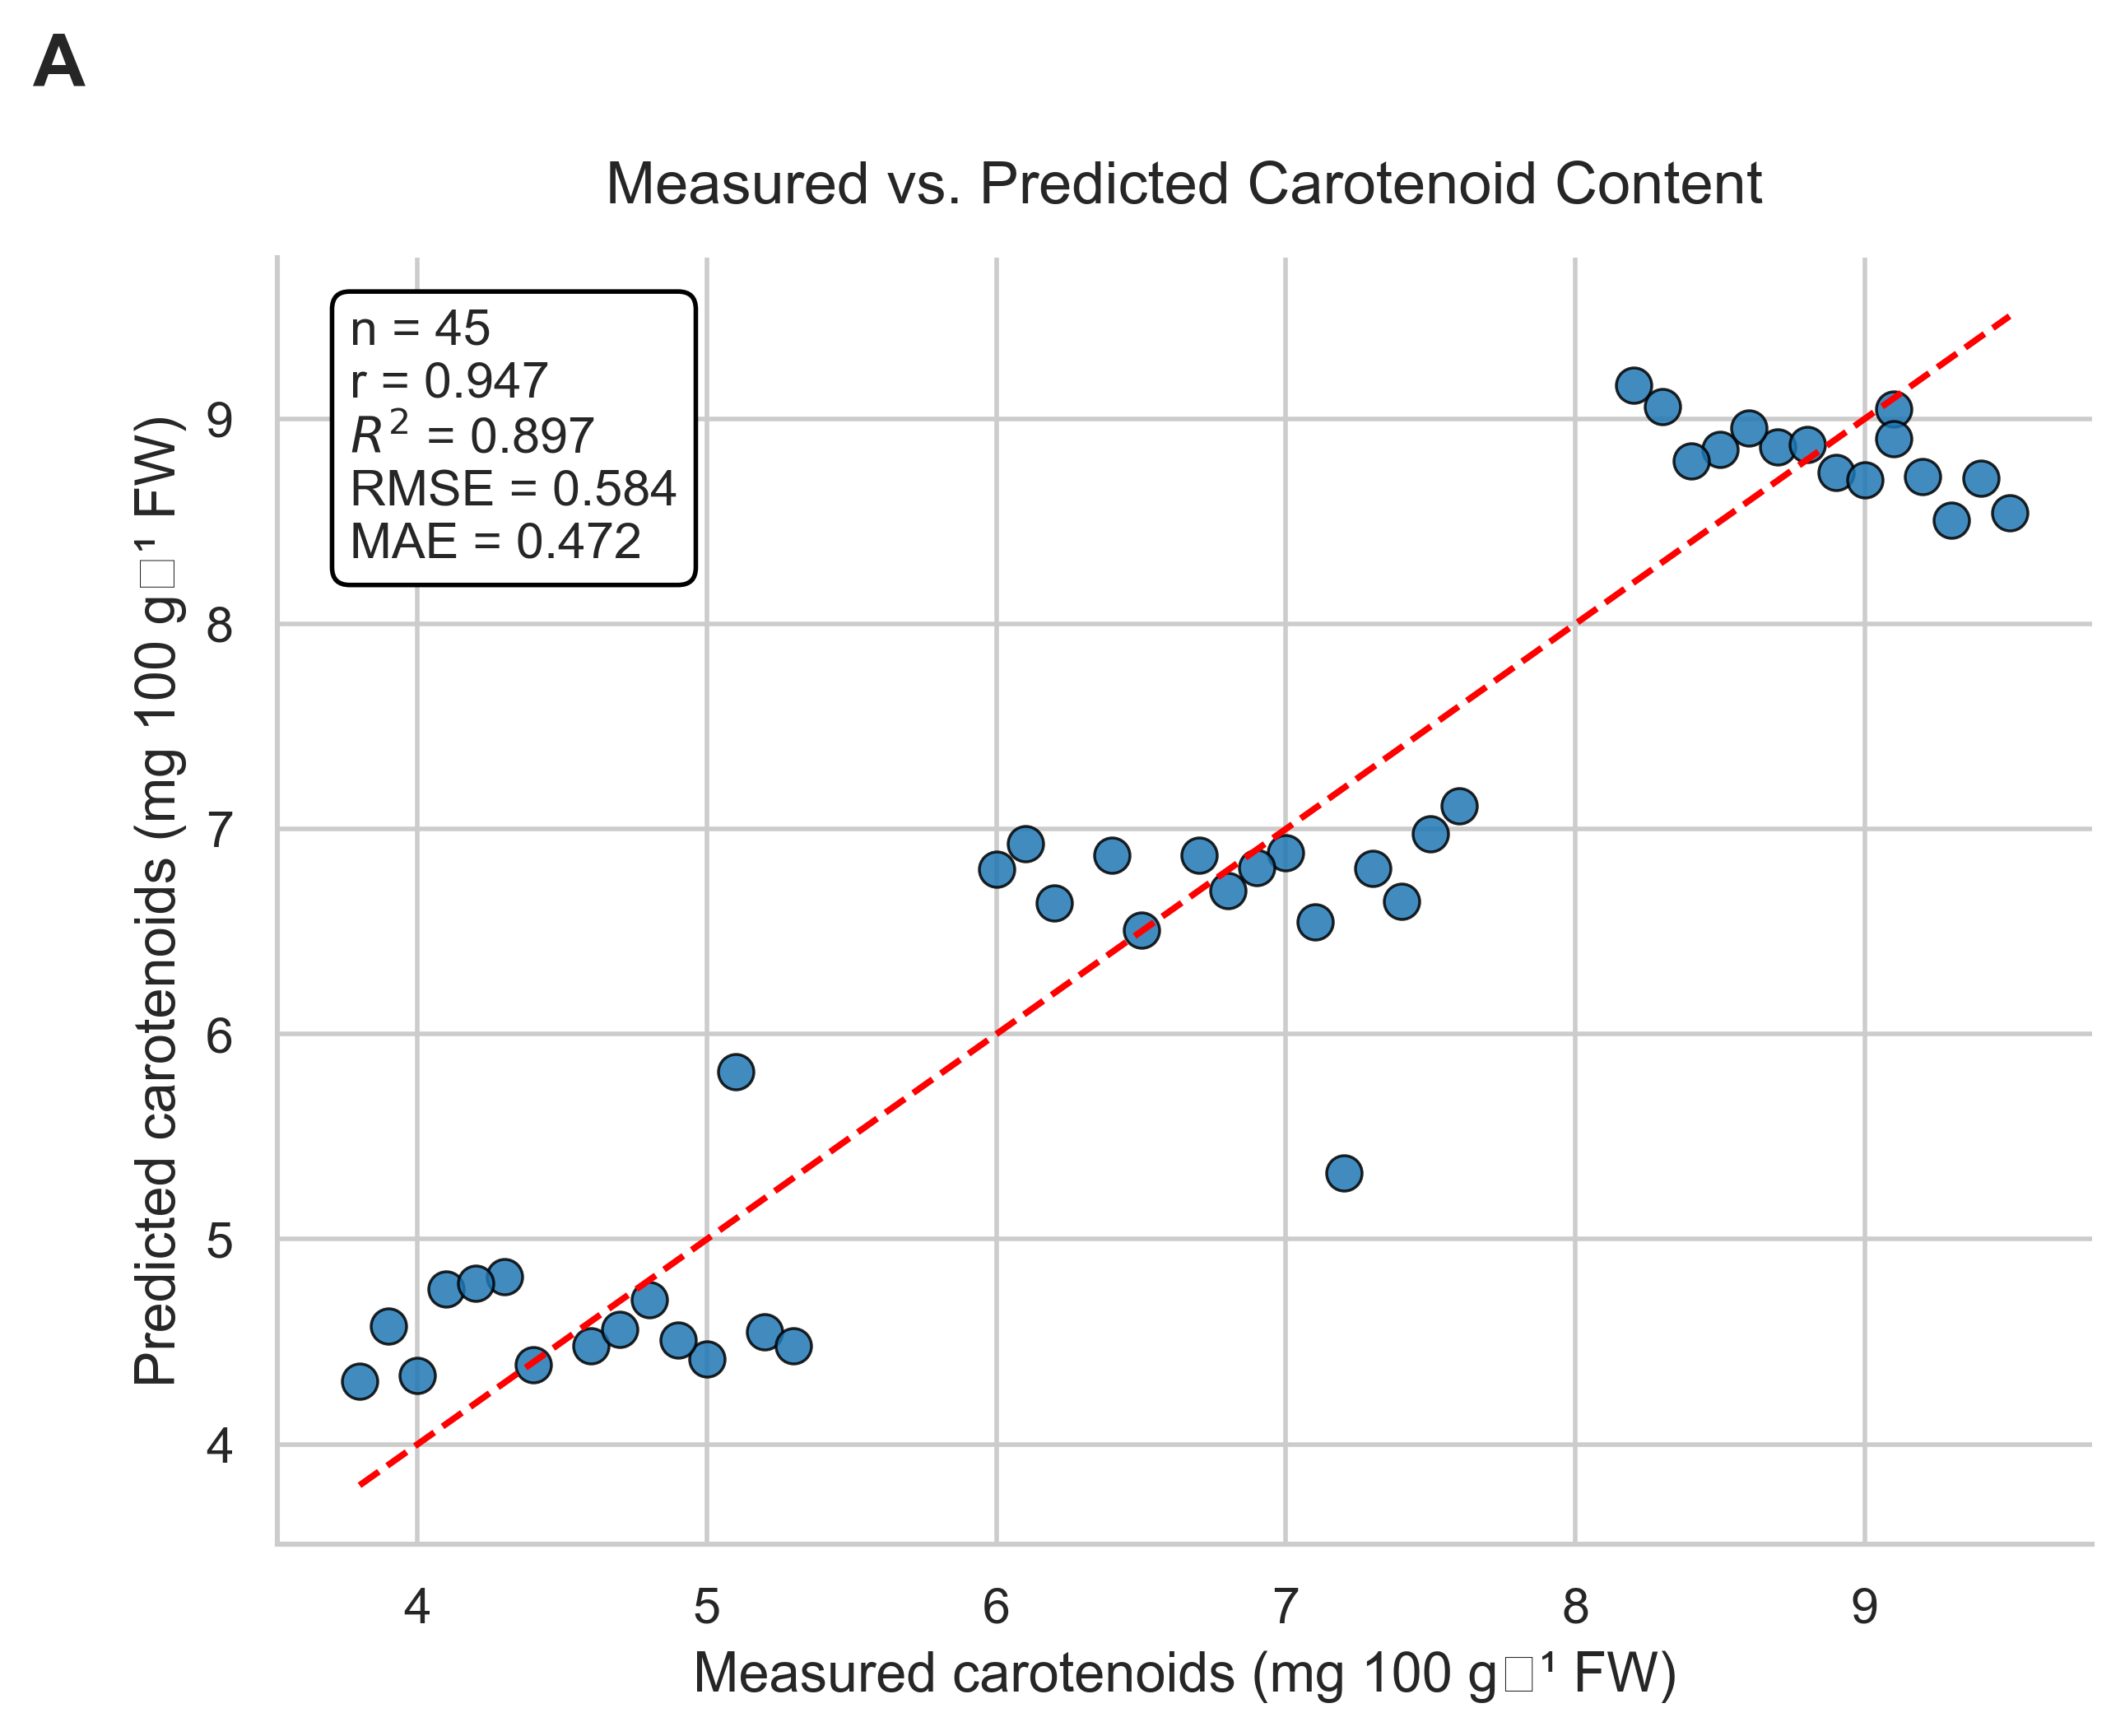

In [9]:
def plot_regression_correlation(y_true, y_pred, fig_label="A",
                                title="Measured vs. Predicted Carotenoid Content",
                                xlabel="Measured carotenoids (mg 100 g⁻¹ FW)",
                                ylabel="Predicted carotenoids (mg 100 g⁻¹ FW)",
                                save_as=None):

    r = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    mae = mean_absolute_error(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6.5, 5.2))

    sns.scatterplot(x=y_true, y=y_pred, s=60, edgecolor="black",
                    color="#1f77b4", alpha=0.85, ax=ax)

    min_v, max_v = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    ax.plot([min_v, max_v], [min_v, max_v], "--", color="red", linewidth=1.4)

    ax.set_title(title, pad=12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.text(0.04, 0.96,
            f"n = {len(y_true)}\n"
            f"r = {r:.3f}\n"
            f"$R^2$ = {r2:.3f}\n"
            f"RMSE = {rmse:.3f}\n"
            f"MAE = {mae:.3f}",
            transform=ax.transAxes,
            fontsize=11,
            verticalalignment="top",
            bbox=dict(boxstyle="round,pad=0.35",
                      facecolor="white",
                      edgecolor="black"))

    fig.text(0.01, 0.98, fig_label, fontsize=16, fontweight="bold")

    plt.tight_layout(rect=[0.03, 0, 1, 0.97])

    if save_as:
        fig.savefig(save_as, bbox_inches="tight")
    plt.show()

# CALL
plot_regression_correlation(
    y_reg, y_pred_reg,
    fig_label="A",
    save_as="Figure3A_Carotenoids.png"
)


In [10]:
# ==========================================================
#   EXTRA: FIT MODEL FOR SHAP EXPLANATION
# ==========================================================
# We fit a fresh Random Forest on the full dataset for SHAP analysis
reg_model_shap = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

reg_model_shap.fit(X_reg, y_reg)

,n_estimators,300
,criterion,'squared_error'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


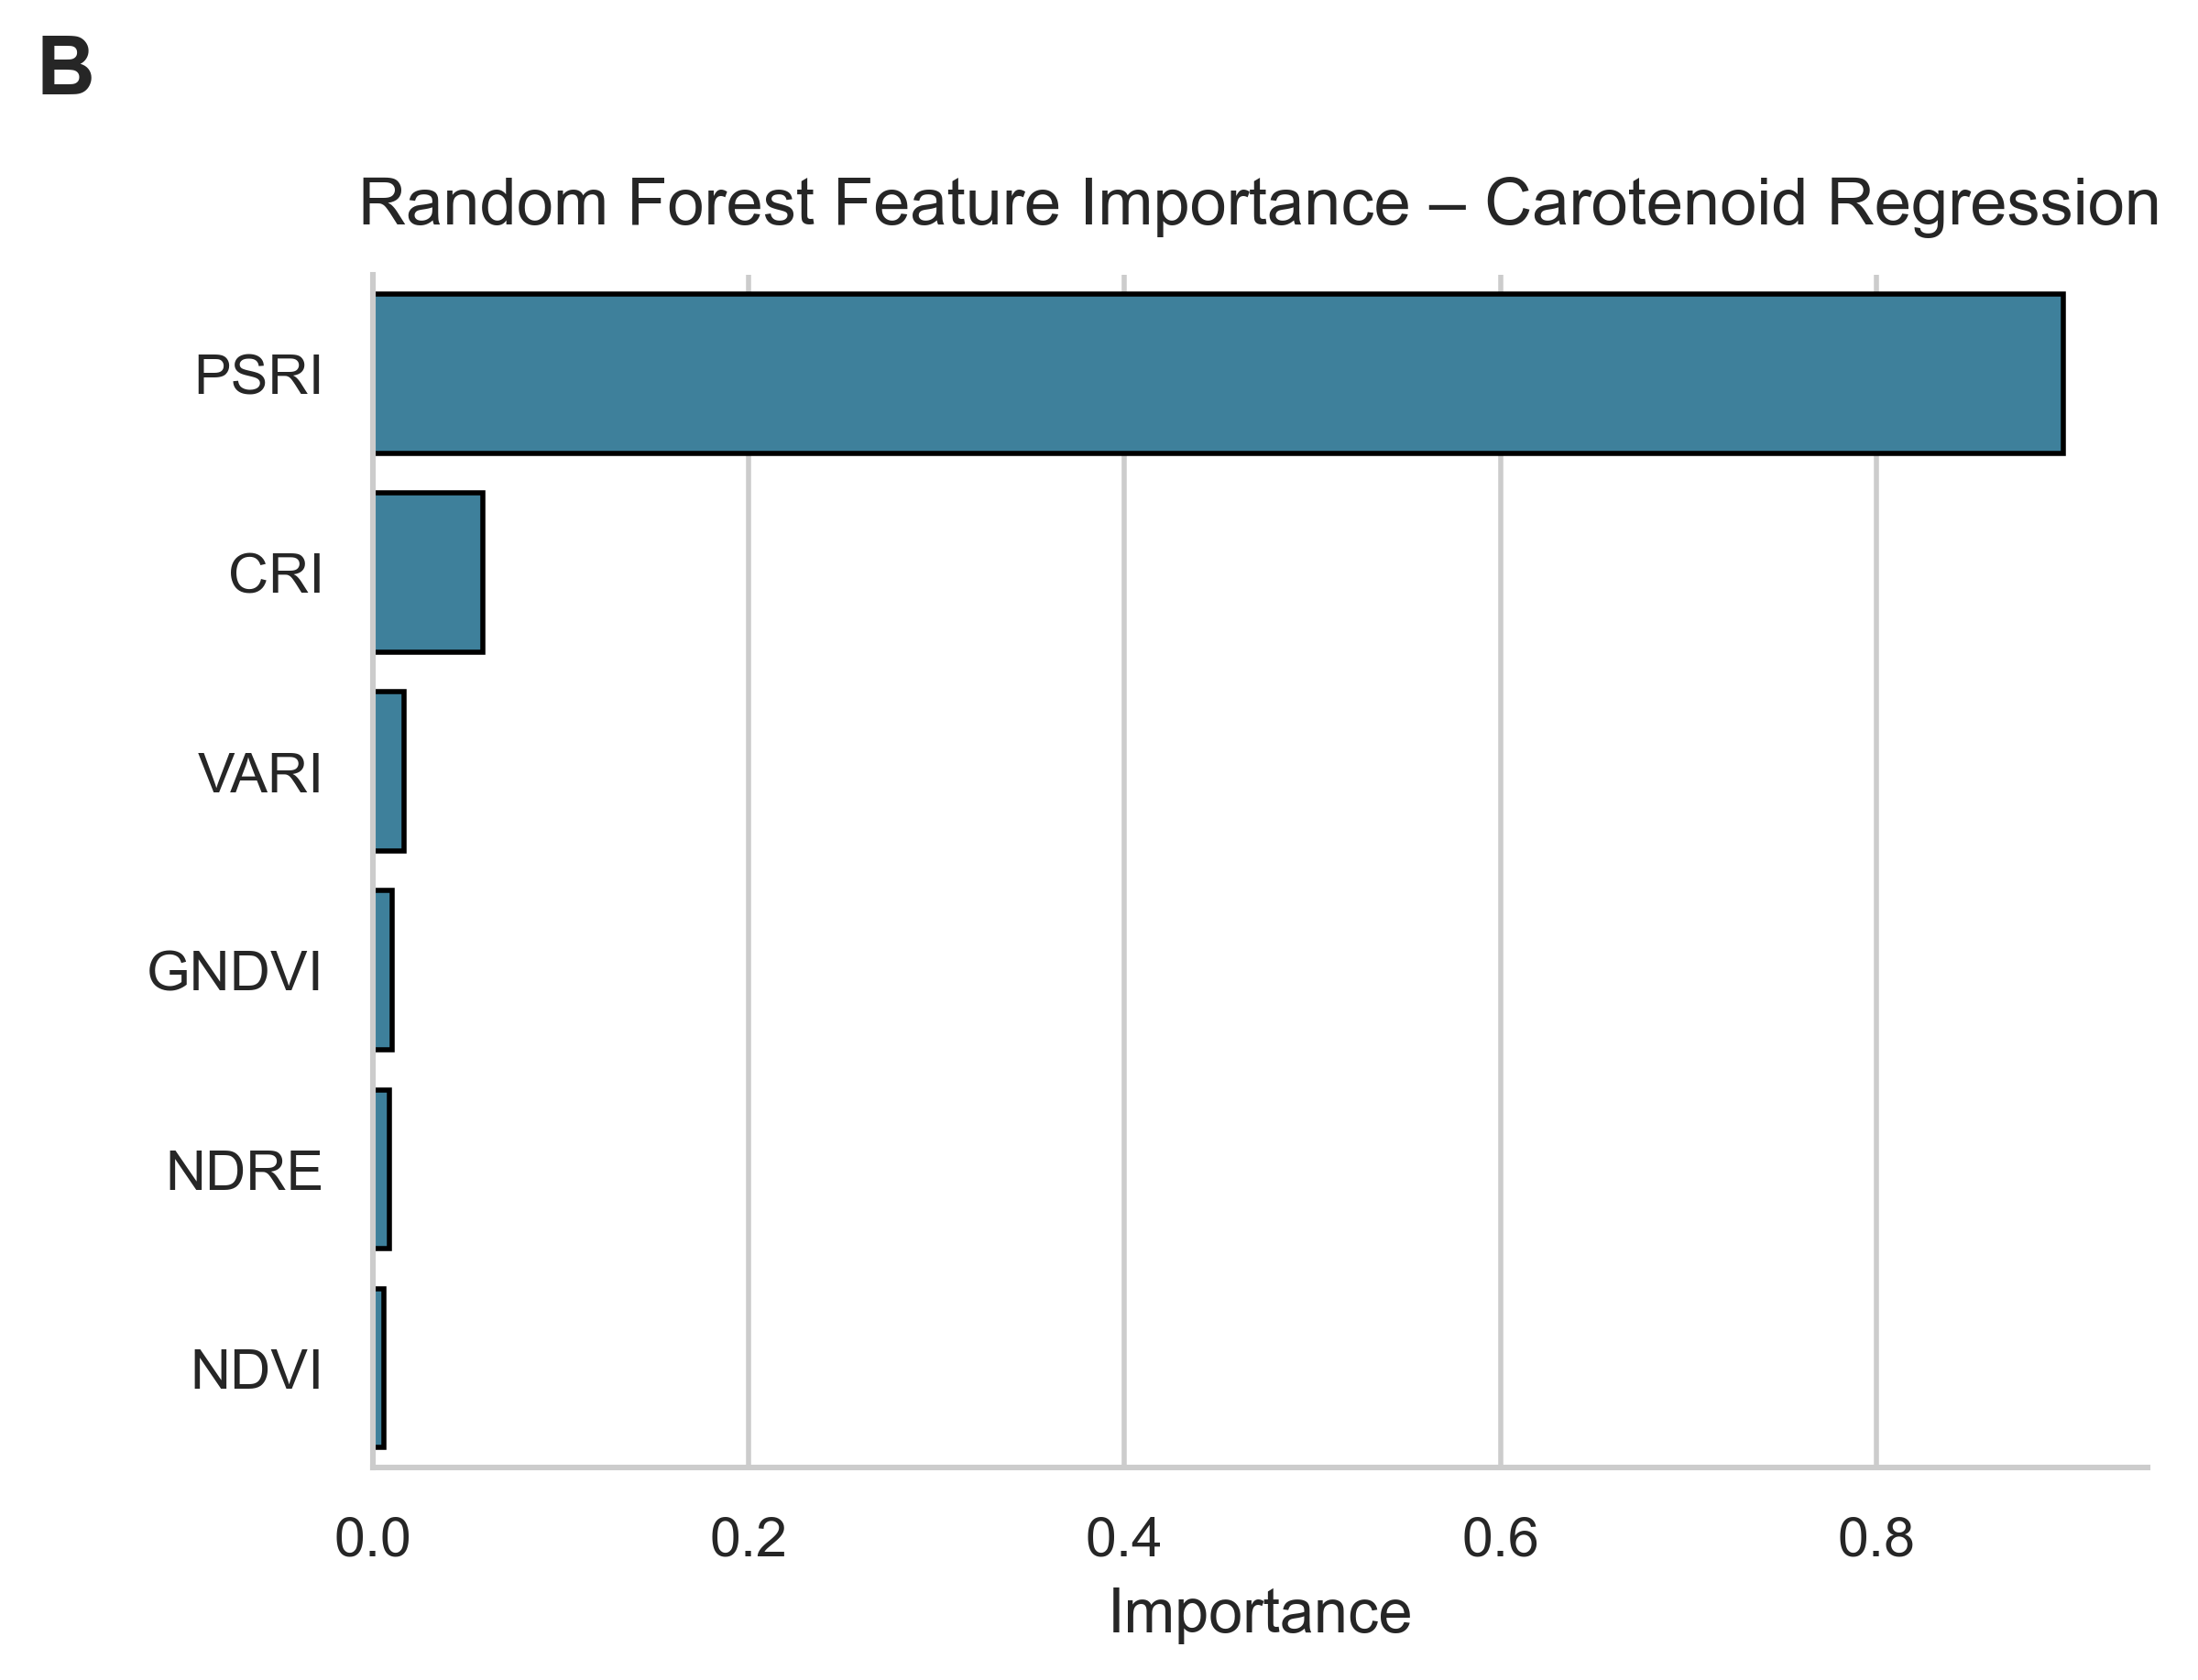

In [11]:
# ==========================================================
#   FEATURE IMPORTANCE (RANDOM FOREST) – CAROTENOIDS
# ==========================================================
def plot_rf_feature_importance(model, feature_names,
                               title="Random Forest Feature Importance – Carotenoid Regression",
                               fig_label="B",
                               save_as=None):

    importances = model.feature_importances_
    df_imp = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values("Importance", ascending=False)

    fig, ax = plt.subplots(figsize=(6, 4.5))

    sns.barplot(
        data=df_imp,
        x="Importance",
        y="Feature",
        color="#2E86AB",
        edgecolor="black",
        ax=ax
    )

    ax.set_title(title, pad=10)
    ax.set_xlabel("Importance")
    ax.set_ylabel("")

    fig.text(0.01, 0.98, fig_label, fontsize=16, fontweight="bold")

    plt.tight_layout(rect=[0.03, 0, 1, 0.97])

    if save_as:
        fig.savefig(save_as, bbox_inches="tight")

    plt.show()

# CALL
plot_rf_feature_importance(
    reg_model_shap,
    feature_cols,
    fig_label="B",
    save_as="Figure3B_RF_FeatureImportance.png"
)


In [16]:
# ==========================================================
#   SHAP ANALYSIS – GLOBAL EXPLANATION
# ==========================================================
import shap

# Create TreeExplainer for the fitted RandomForest
explainer = shap.TreeExplainer(reg_model_shap)

# For a small dataset, we can use all samples
X_shap = X_reg
shap_values = explainer.shap_values(X_shap)

# Convert to DataFrame for readability
X_shap_df = pd.DataFrame(X_shap, columns=feature_cols)


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


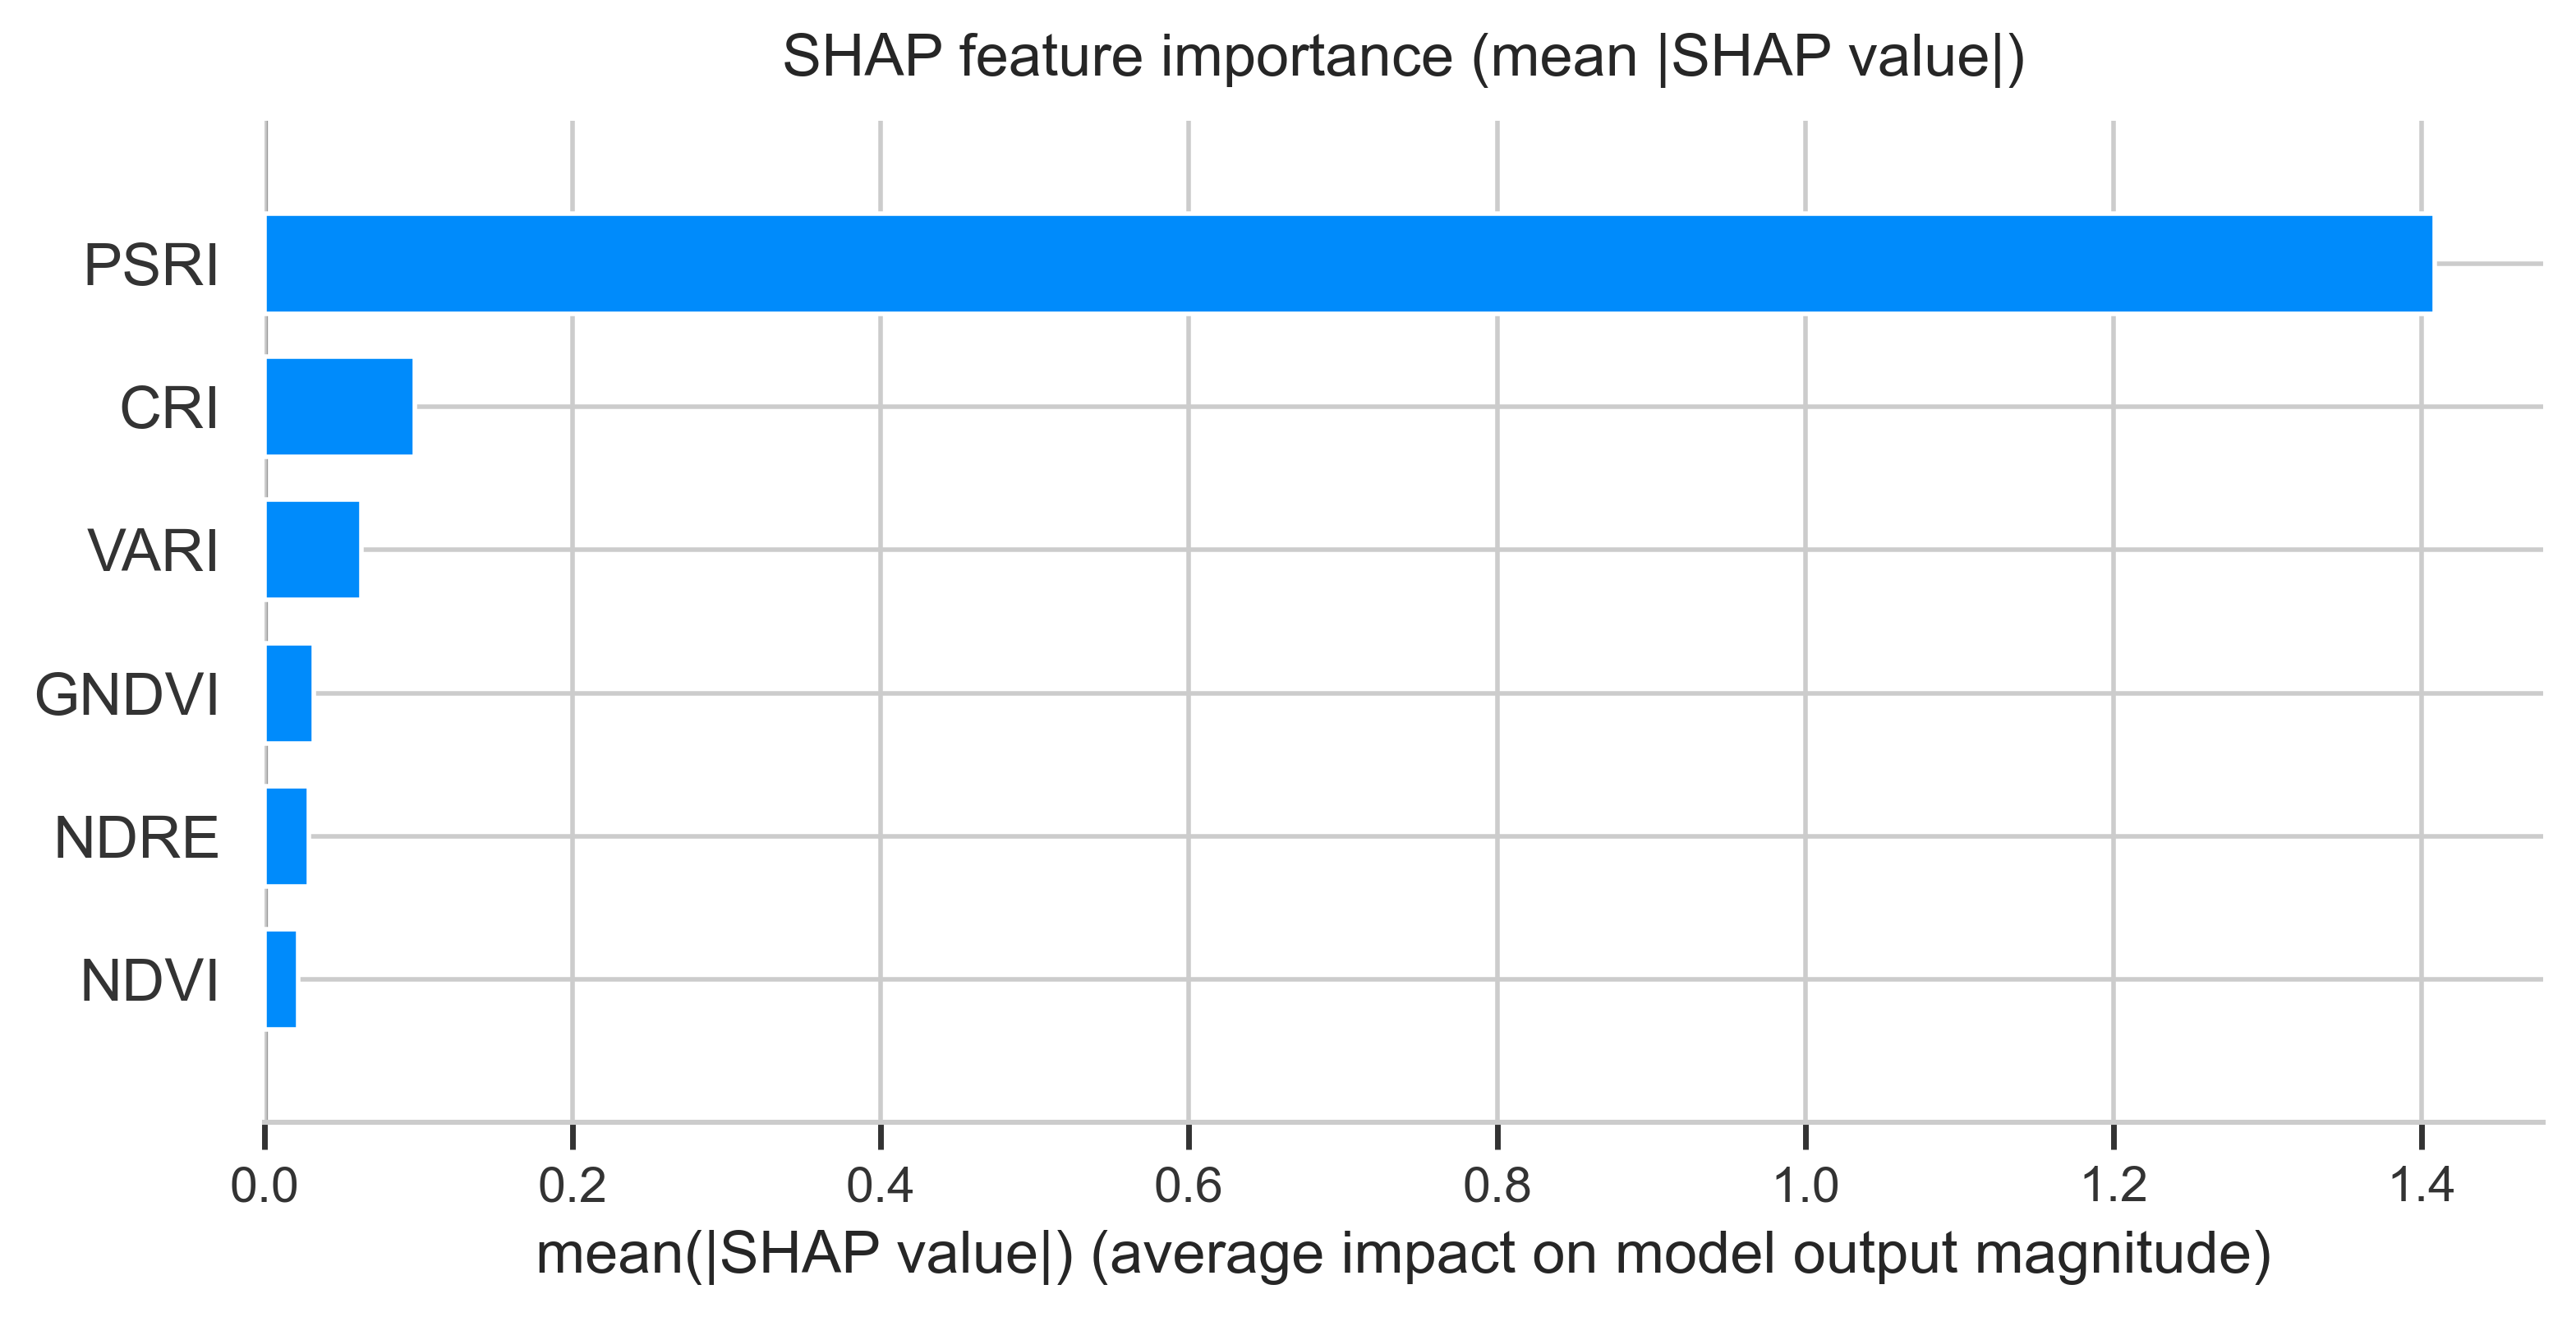

In [17]:
def plot_shap_summary_bar(shap_values, X, feature_names,
                          title="SHAP feature importance (mean |SHAP value|)",
                          save_as=None):

    plt.figure(figsize=(6, 4.5))
    shap.summary_plot(
        shap_values,
        X,
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )
    plt.title(title, pad=10)

    if save_as:
        plt.savefig(save_as, bbox_inches="tight", dpi=400)
    plt.show()

# CALL
plot_shap_summary_bar(
    shap_values,
    X_shap,
    feature_cols,
    save_as="Figure_SHAP_Summary_Bar.png"
)


<Figure size 2400x1800 with 0 Axes>

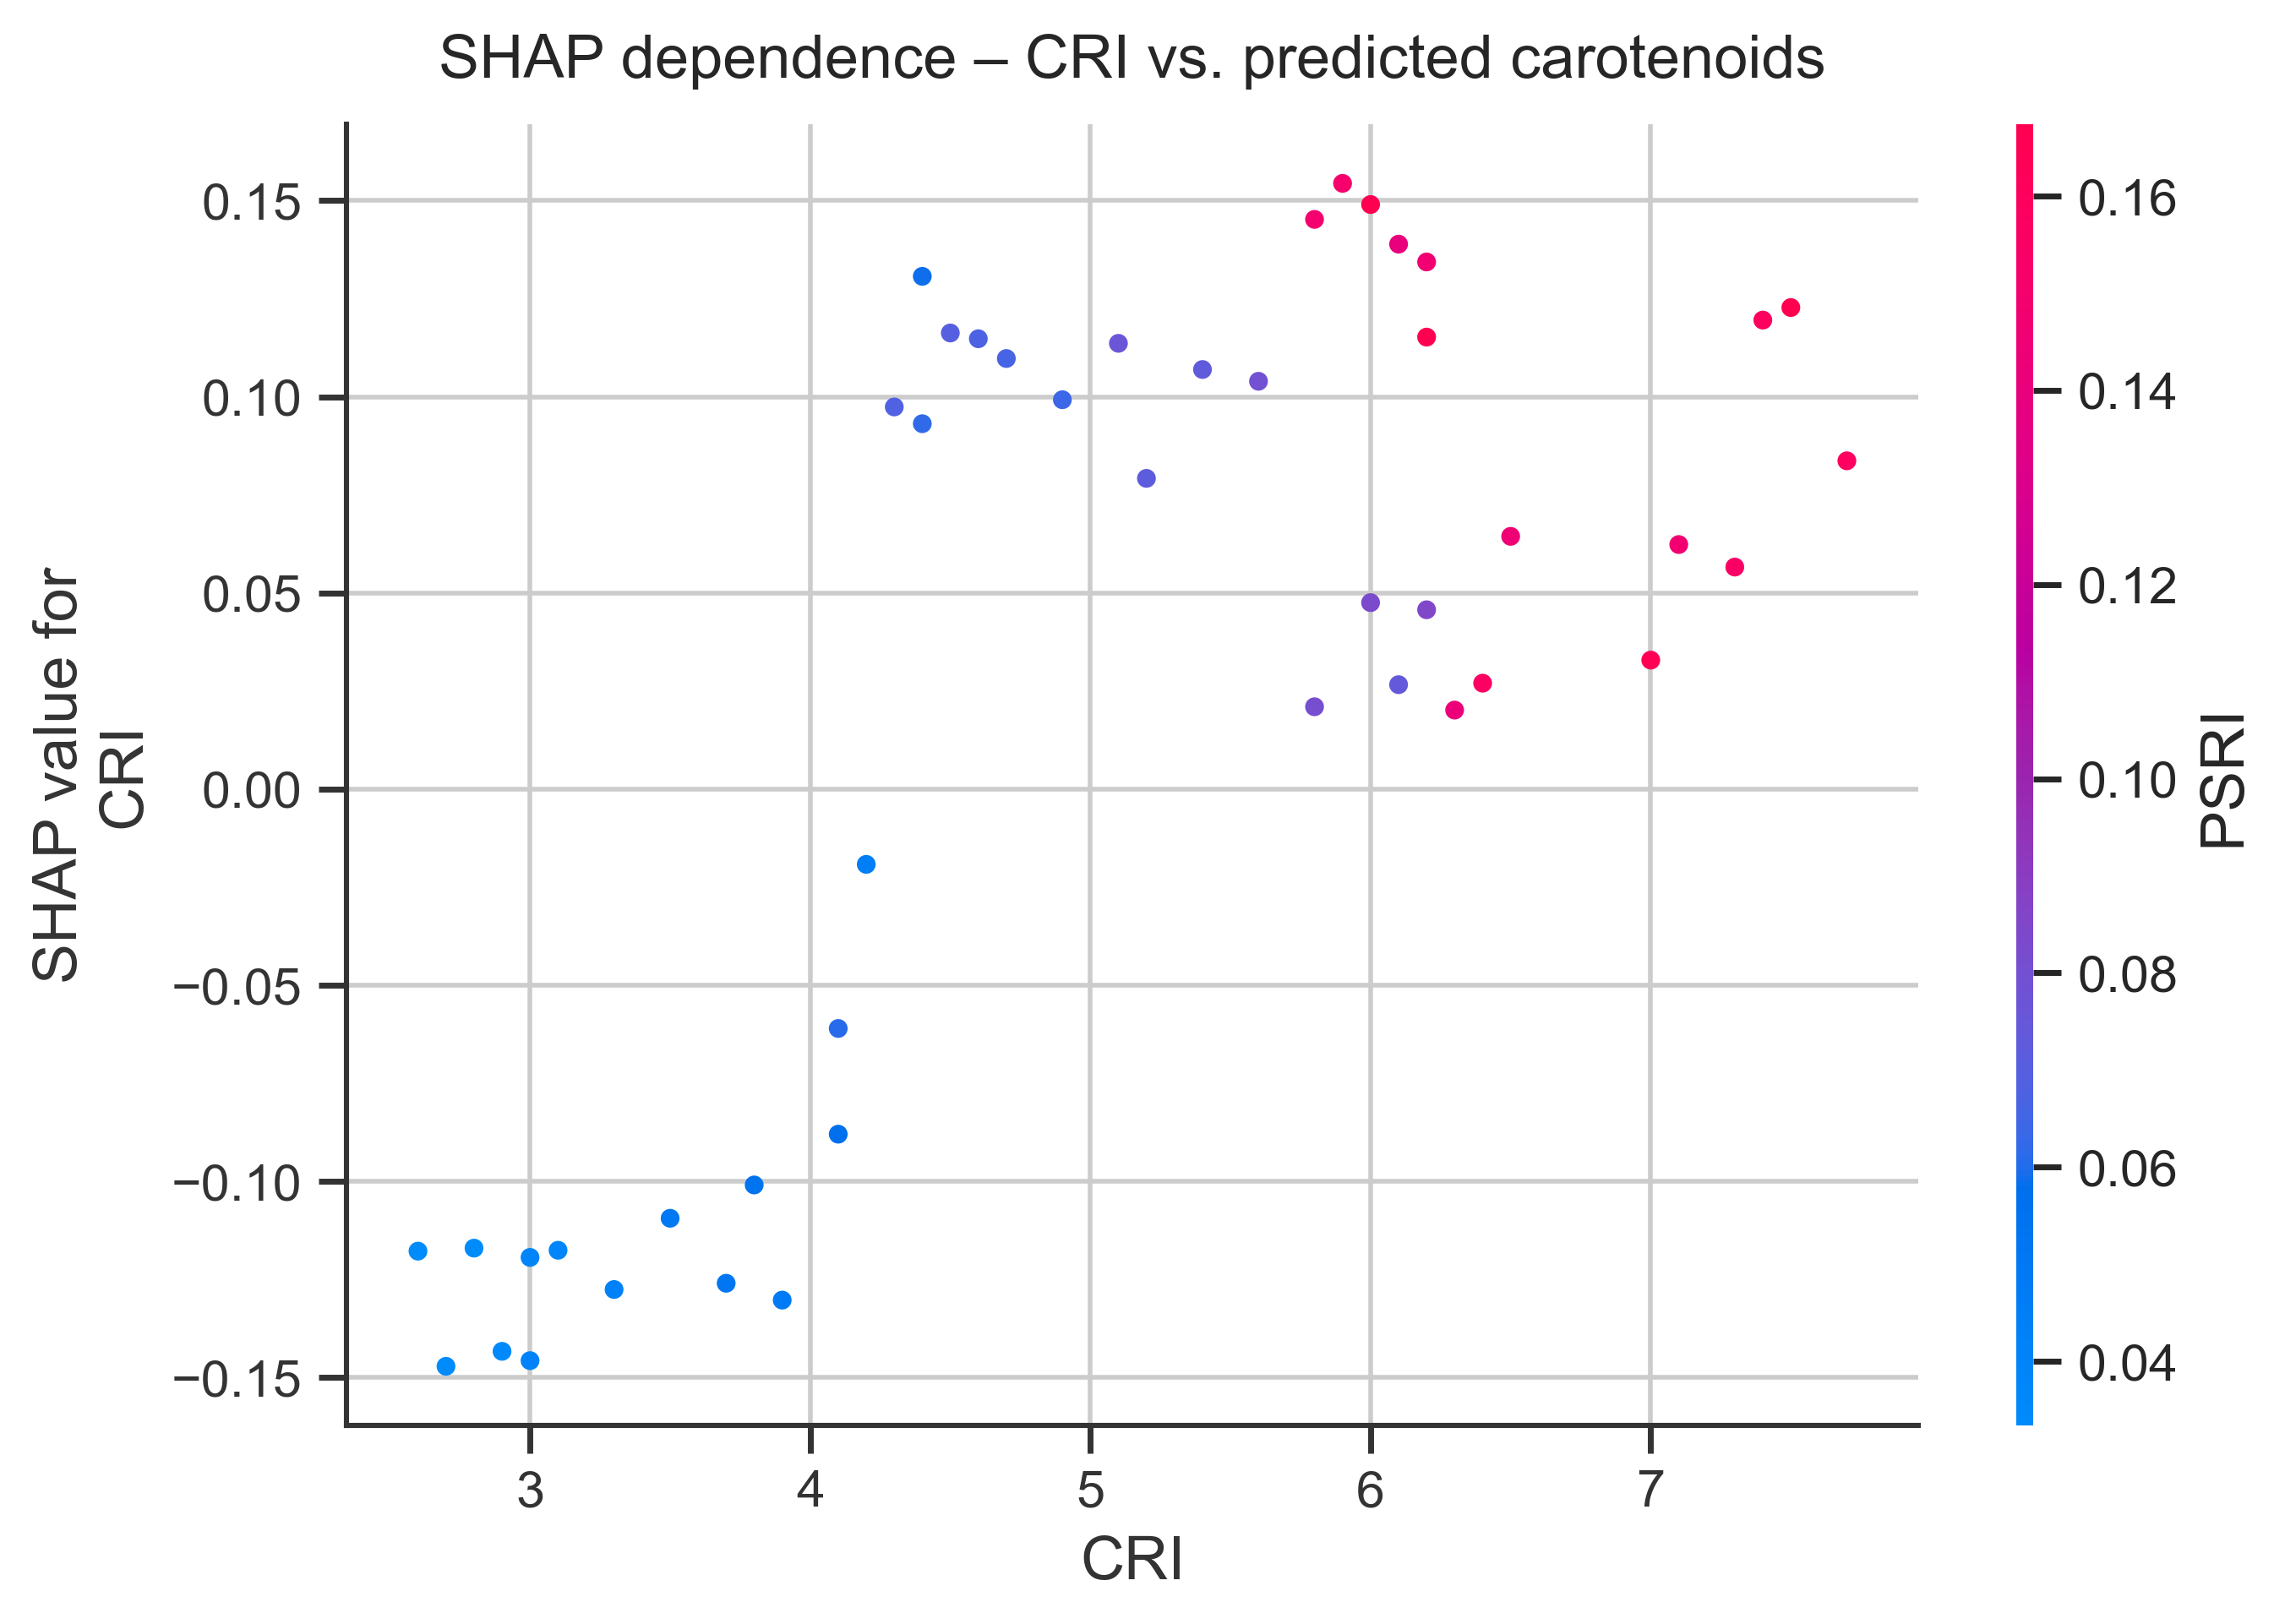

<Figure size 2400x1800 with 0 Axes>

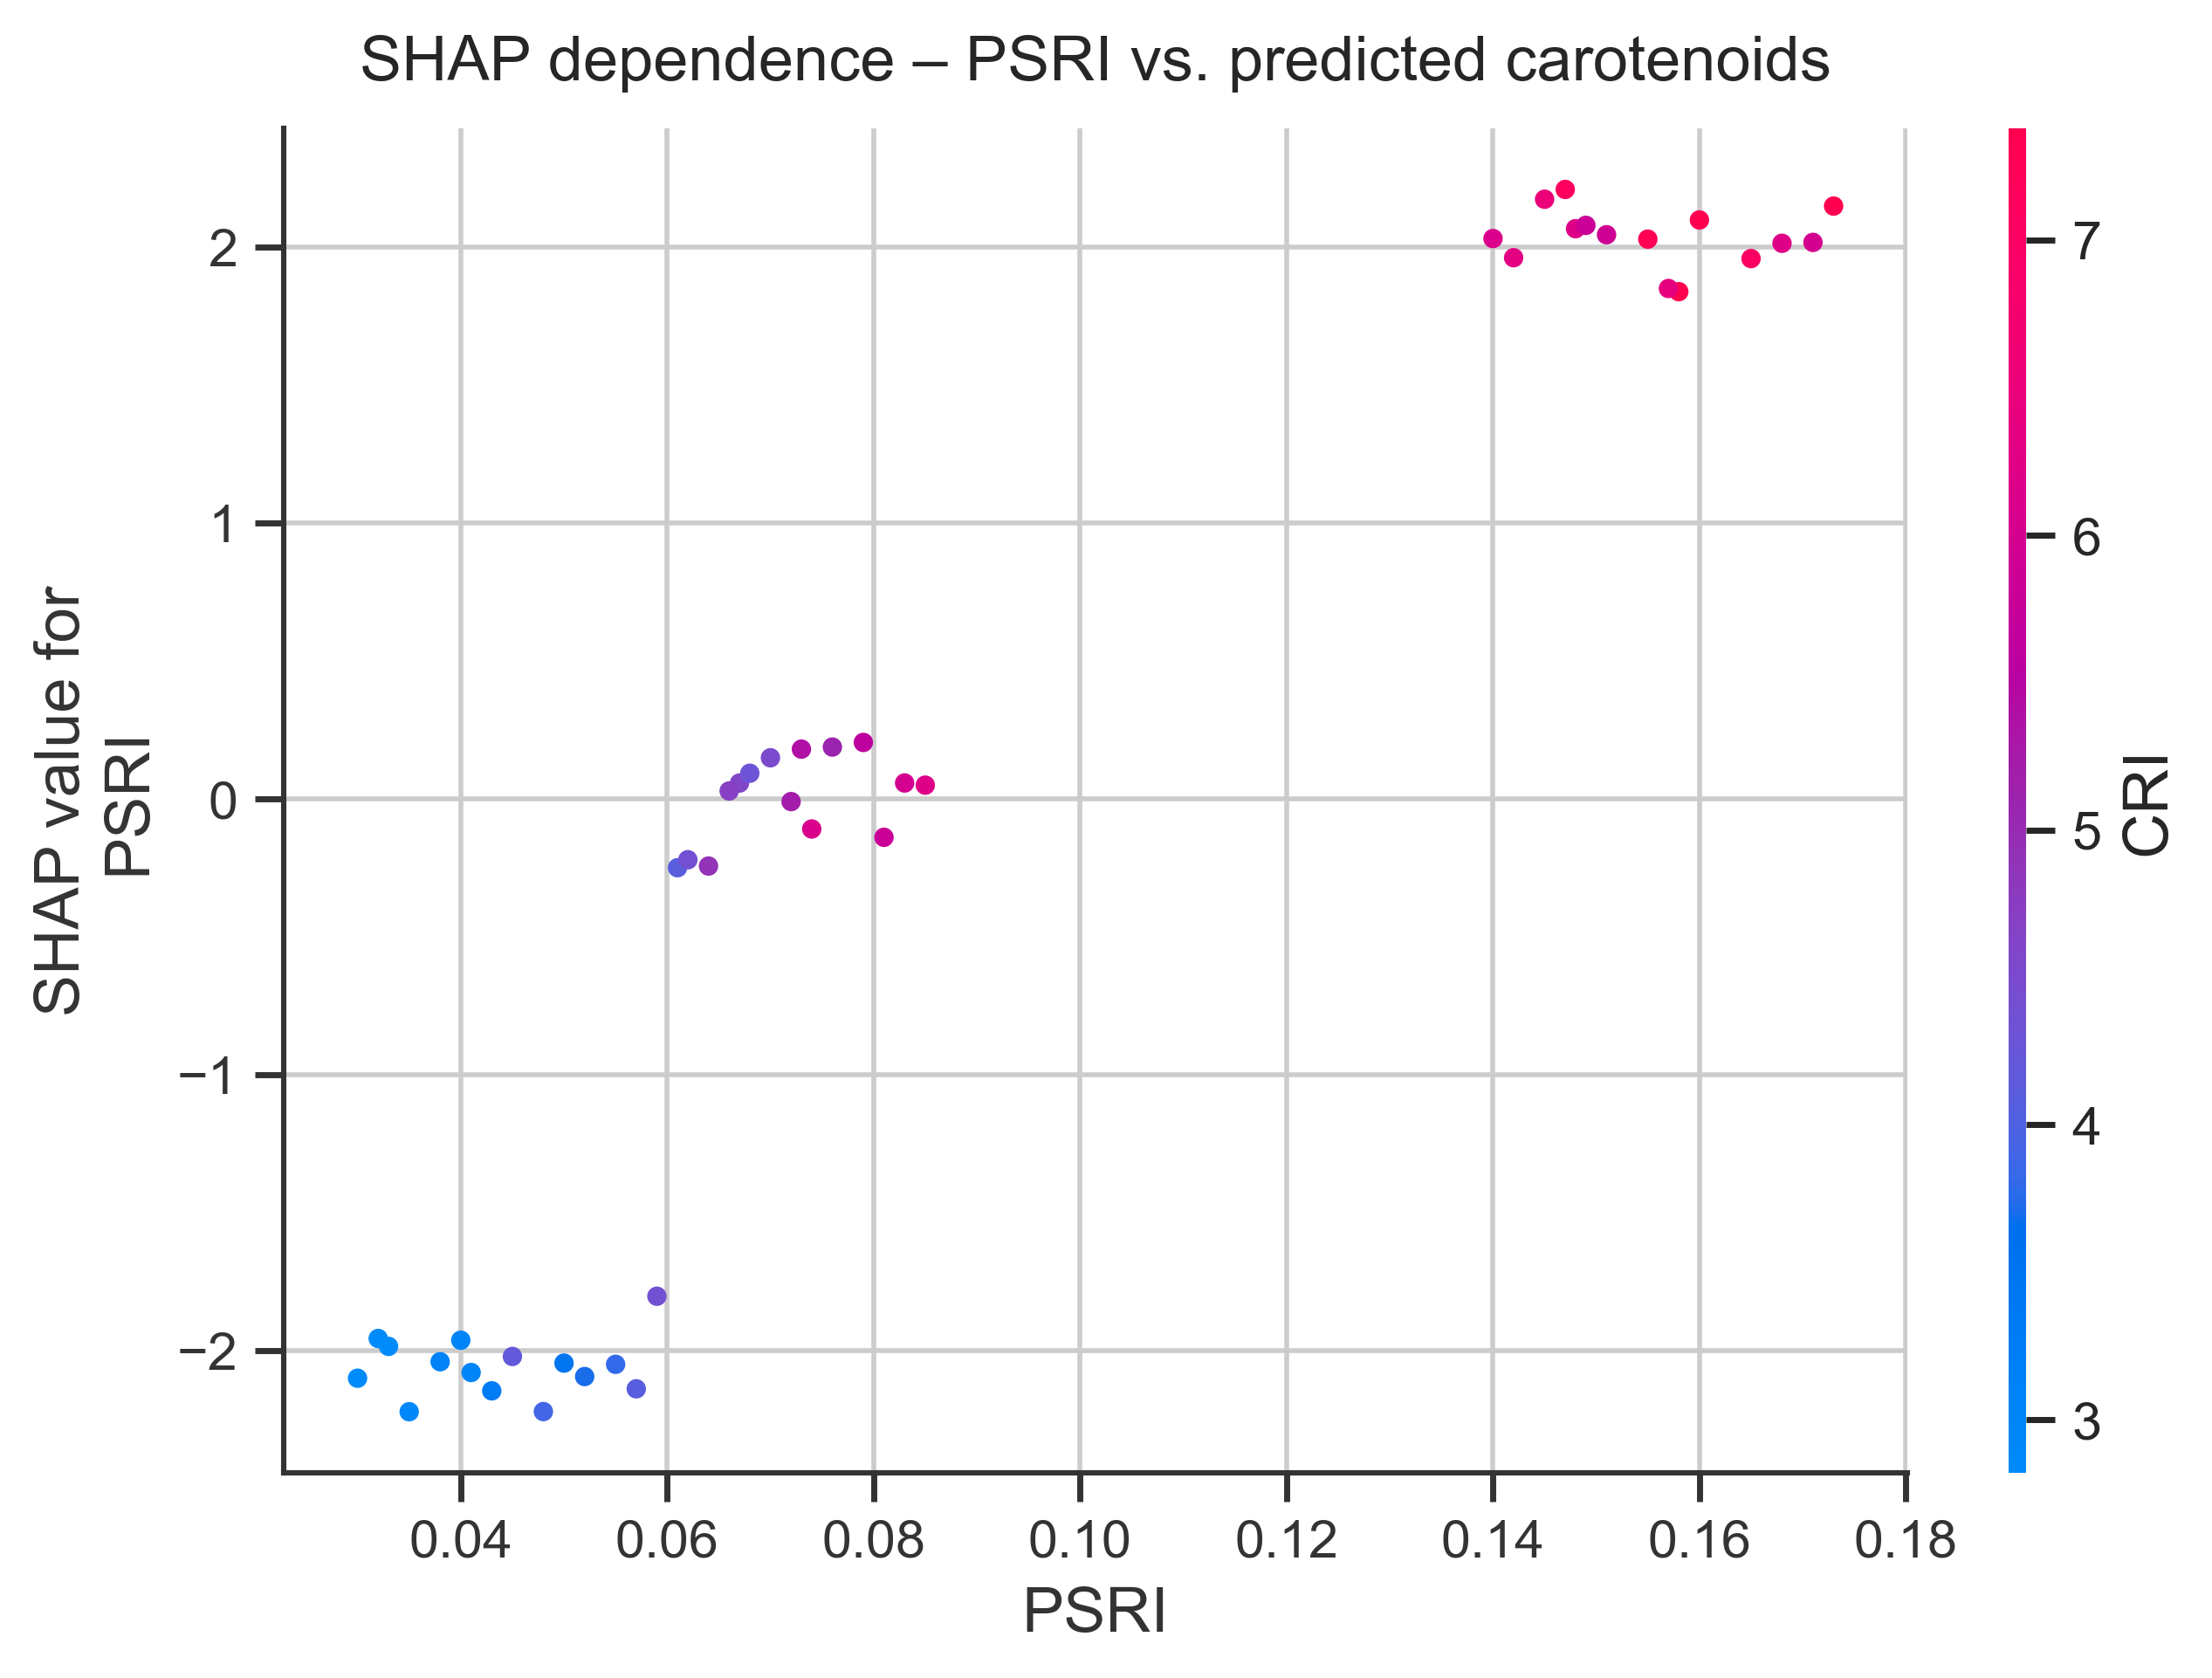

In [18]:
def plot_shap_dependence(shap_values, X_df,
                         feature, interaction_feature=None,
                         title=None,
                         save_as=None):

    plt.figure(figsize=(6, 4.5))
    shap.dependence_plot(
        feature,
        shap_values,
        X_df,
        interaction_index=interaction_feature,
        show=False
    )

    if title:
        plt.title(title, pad=10)

    if save_as:
        plt.savefig(save_as, bbox_inches="tight", dpi=400)
    plt.show()

# Example for CRI
plot_shap_dependence(
    shap_values,
    X_shap_df,
    feature="CRI",
    interaction_feature="PSRI",
    title="SHAP dependence – CRI vs. predicted carotenoids",
    save_as="Figure_SHAP_Dependence_CRI.png"
)

# Example for PSRI
plot_shap_dependence(
    shap_values,
    X_shap_df,
    feature="PSRI",
    interaction_feature="CRI",
    title="SHAP dependence – PSRI vs. predicted carotenoids",
    save_as="Figure_SHAP_Dependence_PSRI.png"
)


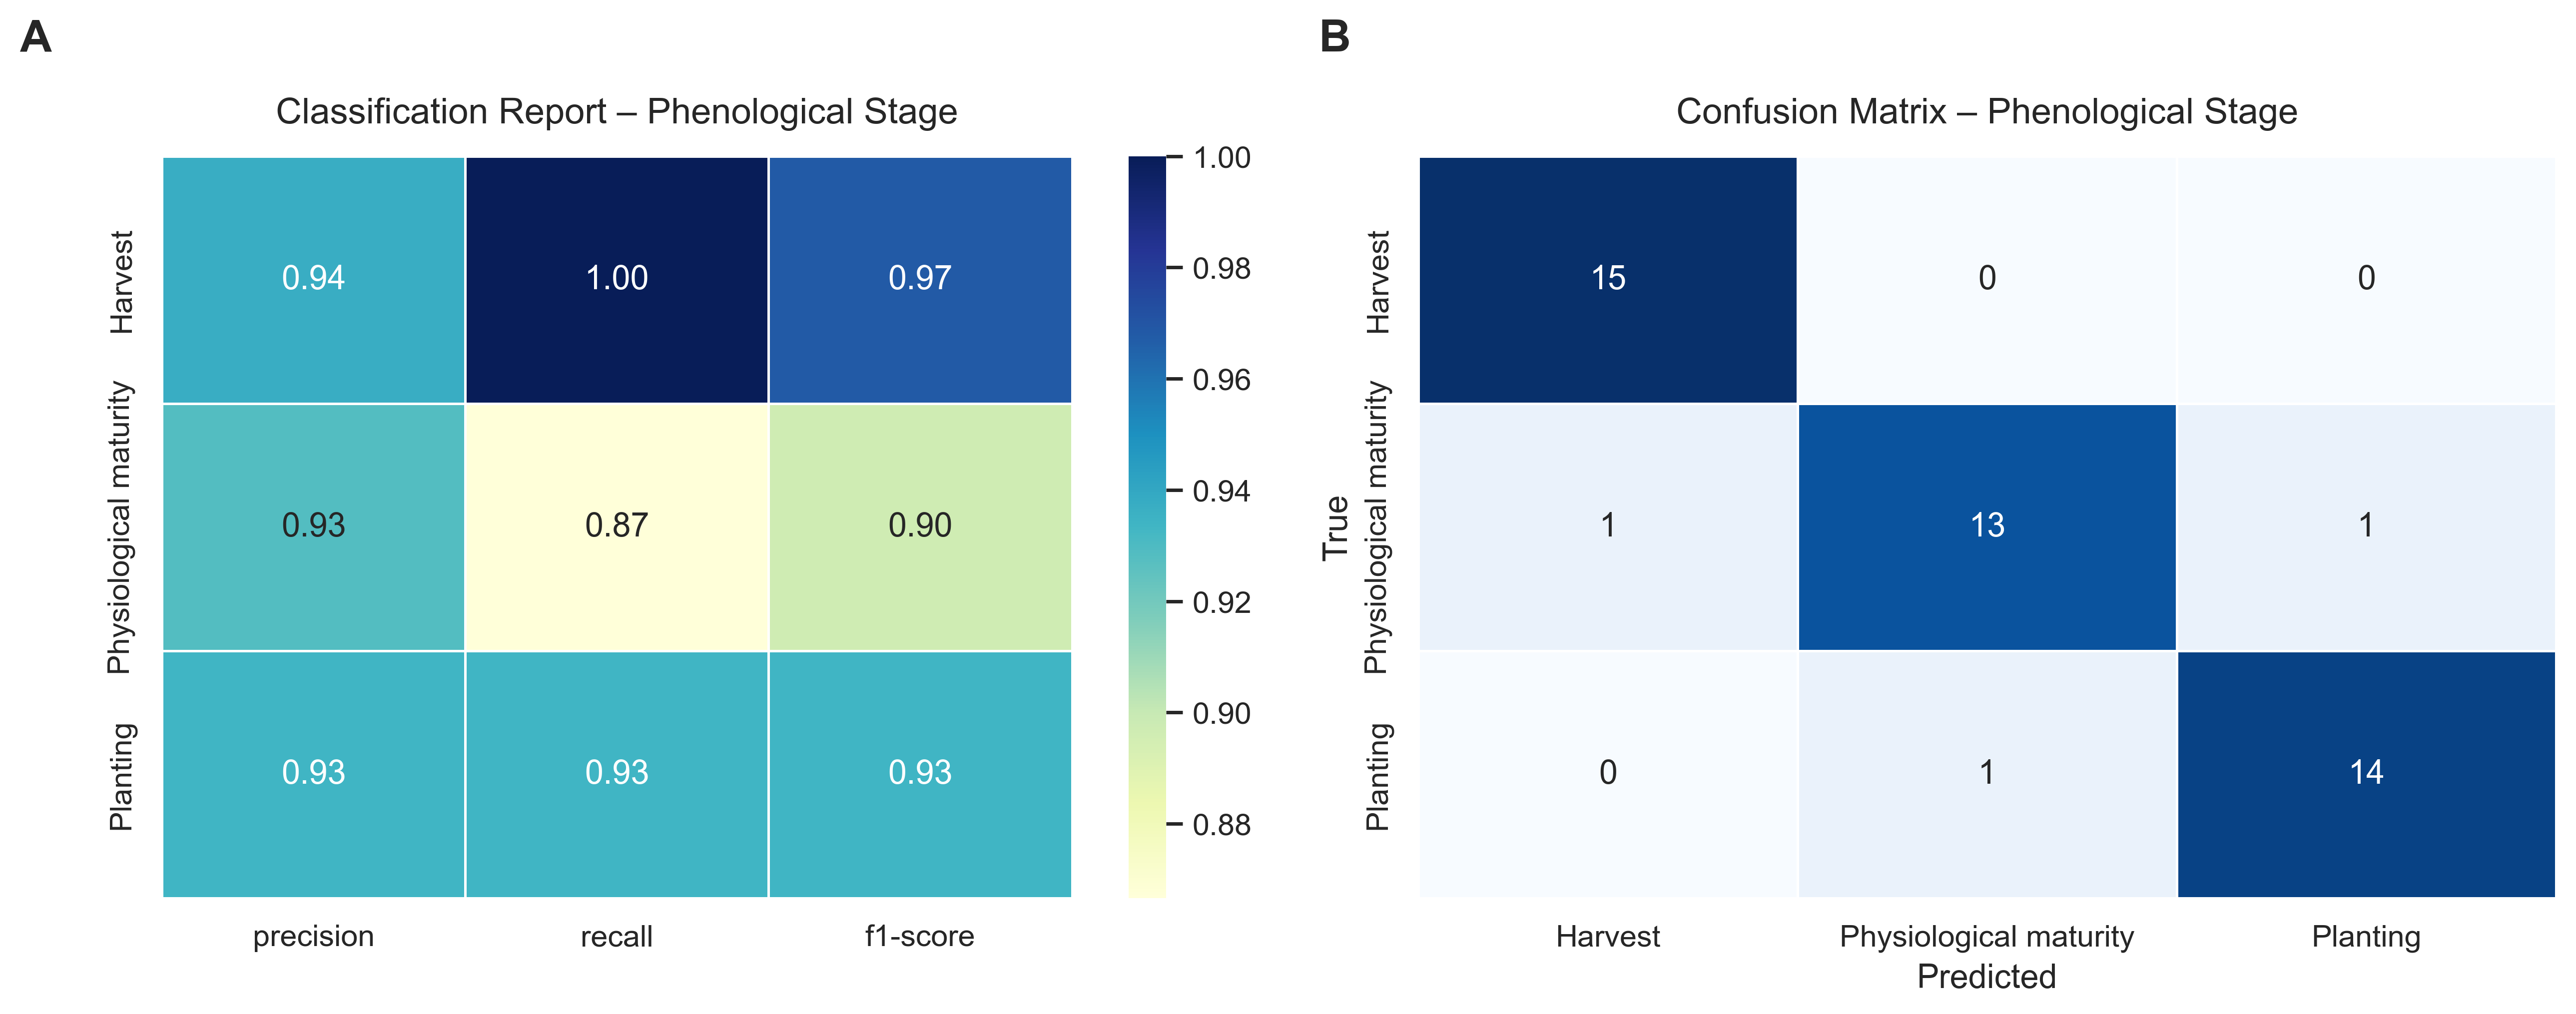

In [19]:
def plot_phenology_classification(y_true, y_pred, save_as=None):

    report = classification_report(y_true, y_pred, output_dict=True)
    df_rep = pd.DataFrame(report).T.iloc[:3, :3]

    labels = sorted(df_rep.index)

    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    # PANEL A – CLASSIFICATION REPORT
    ax1 = axes[0]
    sns.heatmap(df_rep, annot=True, cmap="YlGnBu", fmt=".2f",
                linewidths=.6, linecolor="white", ax=ax1)
    ax1.set_title("Classification Report – Phenological Stage", pad=12)

    # PANEL B – CONFUSION MATRIX
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    ax2 = axes[1]
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
                xticklabels=labels, yticklabels=labels,
                cbar=False, linewidths=.6, linecolor="white", ax=ax2)
    ax2.set_title("Confusion Matrix – Phenological Stage", pad=12)
    ax2.set_xlabel("Predicted")
    ax2.set_ylabel("True")

    fig.text(0.01, 0.98, "A", fontsize=16, fontweight="bold")
    fig.text(0.51, 0.98, "B", fontsize=16, fontweight="bold")

    plt.tight_layout(rect=[0.03, 0, 1, 0.97])

    if save_as:
        fig.savefig(save_as, bbox_inches="tight")

    plt.show()

# CALL
plot_phenology_classification(
    y_clf, y_pred_clf,
    save_as="Figure4_Phenology.png"
)
